# Landscape Evolution Modeling - Gaussian Hill
**Bodo Bookhagen**

For a more detailed introduction and tutorials, please see the [landlab](https://github.com/landlab/landlab), [landlab tutorial](https://nbviewer.jupyter.org/github/landlab/tutorials/blob/master/component_tutorial/component_tutorial.ipynb), and [landlab documentation](https://landlab.readthedocs.io/en/master/) websites.

## Setting up the Model Framework
We will use a Gaussian Hill (as used before) and simulate erosion processes on the Gaussian Hill. We first need to generate a grid and import the Gaussian Hill into the format that can be understand by Landlab. With `RasterModelGrid` we are generating an empty grid with $n*n$ pixels, a `dem_width` of $5*100$ and a node-spacing of `node_spacing = dem_width/n` - because our Gaussian Hill is centered on 0 and runs from -2.5 to 2.5, but we scale this by a factor of 100 to -25 to 25 (50 width).

You could fill the model grid (mg) with zeros (`add_zeros`) via: 
```python
z = mg.add_zeros('node', 'topographic__elevation')
```

We also create a Gaussian hill (via the function *gaussian_hill_elevation* and save this into the create `RasterModelGrid`. The Gaussian hill grid has n=111 elements (111x111) and scale the DEM grid to 100m height and 500m width.

In [1]:
from landlab import RasterModelGrid
import numpy as np
from matplotlib import pyplot as pl
from landlab.plot import imshow_grid
pl.rcParams['figure.figsize'] = [14, 7]

#%% Setting up Gaussian Hill elevation data
n=111
dem_width = 5 * 100
node_spacing = dem_width/n
def gaussian_hill_elevation(n, b = 2.5):
    x, y = np.meshgrid(np.linspace(-b,b,n),
                       np.linspace(-b,b,n))
    z = np.exp(-x*x-y*y)
    return (x, y, z)

x,y,z = gaussian_hill_elevation(n)
z = z*100

mg = RasterModelGrid((n, n), node_spacing)
gh_org = mg.add_field('node', 'topographic__elevation', z, 
                      units='meters', copy=True, clobber=False)

mg is now a grid object with 111x111 nodes and 12321 (111x111) nodes and (111x(111-1)x2) links.

In [2]:
mg.number_of_node_columns

111

In [3]:
mg.number_of_nodes

12321

In [4]:
mg.number_of_links

24420

Let's plot the grid using the `imshow_grid` function from landlab.

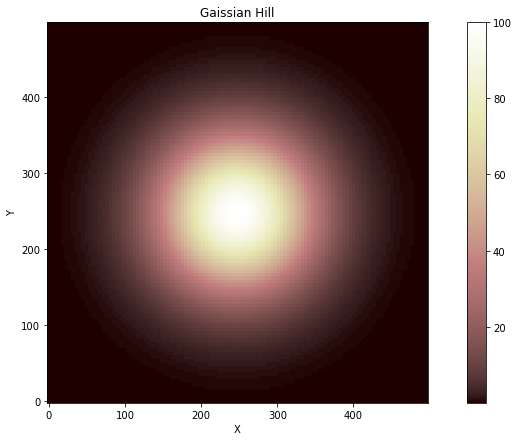

In [5]:
fg1 = pl.figure(1)
imshow_grid(mg, 'topographic__elevation', plot_name='Gaissian Hill', 
            allow_colorbar=True)

In addition, we can plot a profile across the Gaussian Hill:

Text(0.5, 1.0, 'Profile through center of Gaussian Hill at t=0')

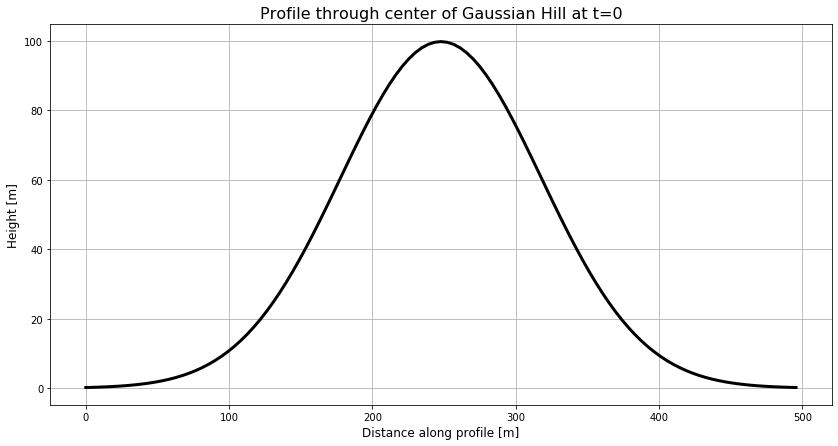

In [6]:
fg2, ax = pl.subplots(1, 1)
crosssection_center = mg.node_vector_to_raster(gh_org, flip_vertically=True)[:,np.int(np.round(n/2))].copy()
crosssection_center_ycoords = mg.node_vector_to_raster(mg.node_y, flip_vertically=True)[:,np.int(np.round(n/2))].copy()
ax.plot(crosssection_center_ycoords, crosssection_center, 'k', linewidth=3, label='Org. Gaussian Hill')
ax.grid()
ax.set_xlabel('Distance along profile [m]', fontsize=12)
ax.set_ylabel('Height [m]', fontsize=12)
ax.set_title('Profile through center of Gaussian Hill at t=0', fontsize=16)

## Setting up the Diffusion Modeler
Next, we initiate the boundary conditions for the diffusion modeler. We close all sides and assume a diffusion coefficient of $0.1 m^2/y$. We run one modeling step that integrates over 1000y.

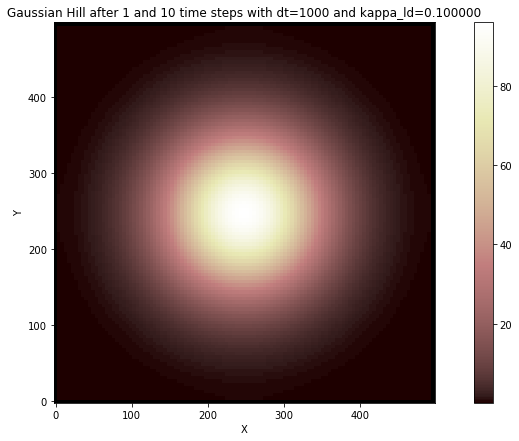

In [7]:
from landlab.components import LinearDiffuser
mg.set_closed_boundaries_at_grid_edges(True, True, True, True)
kappa_ld = 0.1 # m^2/y [L^2/T]
ld = LinearDiffuser(mg, linear_diffusivity=kappa_ld)
dt = 1000 # time step in y
ld.run_one_step(dt)

fg3 = pl.figure()
imshow_grid(mg, 'topographic__elevation', plot_name='Gaussian Hill after 1 and 10 time steps with dt=%d and kappa_ld=%f'%(dt, kappa_ld), 
            allow_colorbar=True)

We can save the resulting grid to a separate variable and generate a profile across the diffused Gaussian Hill:

In [8]:
gh_ld1 = mg.node_vector_to_raster(gh_org, flip_vertically=True)

crosssection_center_d1 = mg.node_vector_to_raster(gh_ld1, flip_vertically=True)[:,np.int(np.round(n/2))]
crosssection_center_ycoords_d1 = mg.node_vector_to_raster(mg.node_y, flip_vertically=True)[:,np.int(np.round(n/2))]

This can be plotted together with the original profile:

Text(0.5, 1.0, 'Profile through center of Gaussian Hill at t=0')

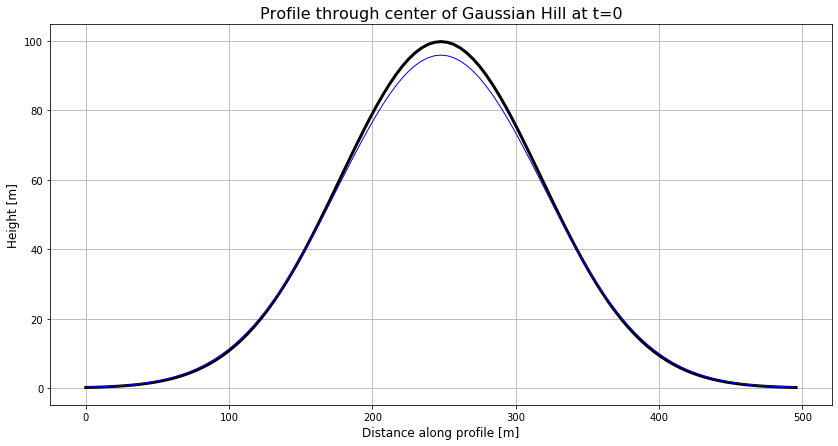

In [9]:
fg2, ax = pl.subplots(1, 1)
ax.plot(crosssection_center_ycoords, crosssection_center, 'k', linewidth=3, label='Org. Gaussian Hill')
ax.plot(crosssection_center_ycoords_d1, crosssection_center_d1, 'b', linewidth=1, label='n=1, dt=%d x k=%02.2f'%(dt, kappa_ld))
ax.grid() 
ax.set_xlabel('Distance along profile [m]', fontsize=12)
ax.set_ylabel('Height [m]', fontsize=12)
ax.set_title('Profile through center of Gaussian Hill at t=0', fontsize=16)

We can use the same setup and run the model through a `for` loop - here for 10 times - and plot the resulting DEM.

0
1
2
3
4
5
6
7
8
9


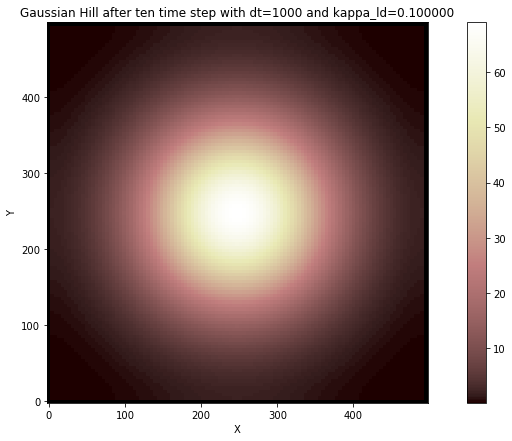

In [10]:
dt = 1000 # time step in yr
for i in range(10):
    ld.run_one_step(dt)
    print('%d'%(i))

fg5 = pl.figure()
imshow_grid(mg, 'topographic__elevation', plot_name='Gaussian Hill after ten time step with dt=%d and kappa_ld=%f'%(dt, kappa_ld), 
            allow_colorbar=True)

Again, the results after 10 model steps (each 1000 y - a total of 10ky model time) can be visualized through profiles:

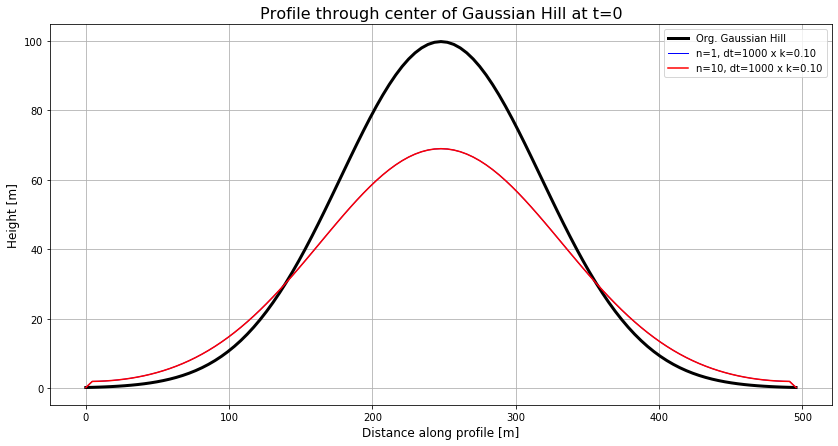

In [11]:
gh_ld2 = mg.node_vector_to_raster(gh_org, flip_vertically=True)

crosssection_center_d2 = mg.node_vector_to_raster(gh_ld2, flip_vertically=True)[:,np.int(np.round(n/2))]
crosssection_center_ycoords_d2 = mg.node_vector_to_raster(mg.node_y, flip_vertically=True)[:,np.int(np.round(n/2))]

fg2, ax = pl.subplots(1, 1)
ax.plot(crosssection_center_ycoords, crosssection_center, 'k', linewidth=3, label='Org. Gaussian Hill')
ax.plot(crosssection_center_ycoords_d1, crosssection_center_d1, 'b', linewidth=1, label='n=1, dt=%d x k=%02.2f'%(dt, kappa_ld))
ax.plot(crosssection_center_ycoords_d2, crosssection_center_d2, 'r', label='n=10, dt=%d x k=%02.2f'%(dt, kappa_ld))
ax.grid() 
ax.set_xlabel('Distance along profile [m]', fontsize=12)
ax.set_ylabel('Height [m]', fontsize=12)
ax.set_title('Profile through center of Gaussian Hill at t=0', fontsize=16)
ax.legend()

## Plotting each individual Model Results
In the above example, only the final steps are plotted and shown as profile. We can extract the results from each modeling step and can better evaluate the dynamics of the terrain by plotting the results of each time step individually. We do this within the for loop. Let's set up our model again and plot every time step (2000 y steps for 20 times):

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


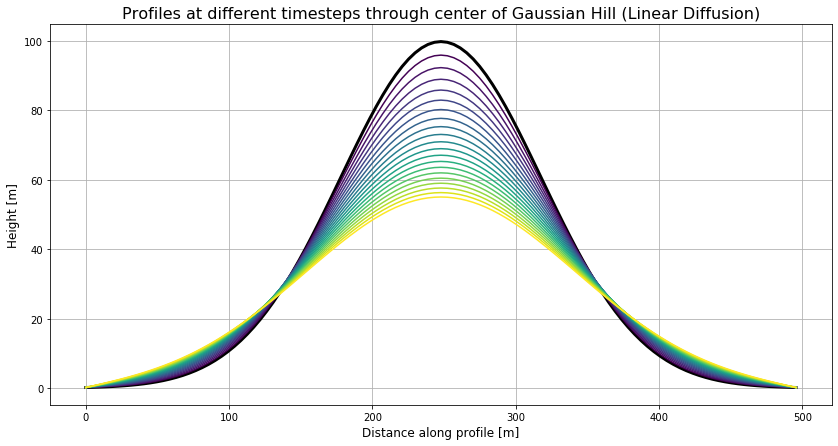

In [12]:
#Create initial plot of raw data
fg2, ax = pl.subplots(1, 1)
ax.plot(crosssection_center_ycoords, crosssection_center, 'k', linewidth=3, label='Org. Gaussian Hill')
ax.grid()
ax.set_xlabel('Distance along profile [m]', fontsize=12)
ax.set_ylabel('Height [m]', fontsize=12)
ax.set_title('Profiles at different timesteps through center of Gaussian Hill (Linear Diffusion)', fontsize=16)

#re-initiate model domain to start from scratch
x,y,z = gaussian_hill_elevation(n)
z = z*100

mg = RasterModelGrid((n, n), node_spacing)
gh_org = mg.add_field('node', 'topographic__elevation', z, units='meters', copy=True, clobber=False)
kappa_ld = 0.05 # m^2/y [L^2/T]
ld = LinearDiffuser(mg, linear_diffusivity=kappa_ld)
dt = 2000 # time step in y
time_steps = 20 
crosssection_center_dt = np.empty((time_steps, len(crosssection_center_d1)))
crosssection_center_ycoords_dt = np.empty((time_steps, len(crosssection_center_ycoords_d1)))
colors = pl.cm.viridis(np.linspace(0,1,time_steps))
for i in range(time_steps):
    ld.run_one_step(dt)
    gh_ld = mg.node_vector_to_raster(gh_org, flip_vertically=True)
    
    crosssection_center_dt[i,:] = mg.node_vector_to_raster(gh_ld, flip_vertically=True)[:,np.int(np.round(n/2))]
    crosssection_center_ycoords_dt[i,:] = mg.node_vector_to_raster(mg.node_y, flip_vertically=True)[:,np.int(np.round(n/2))]
    ax.plot(crosssection_center_ycoords_dt[i,:], 
                 crosssection_center_dt[i,:], 
                 color=colors[i], label='dt=%d'%(dt))    
    print('%d'%(i))

## Gaussian Hill with Topographic Noise
We will add some topographic noise to the Gaussian Hill to make a more realistic setup. The Gaussian Hill with noise is plotted below.

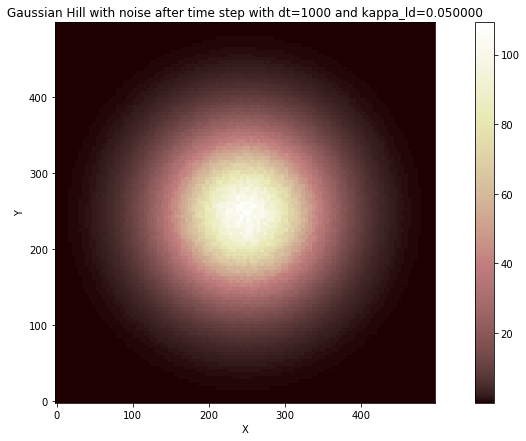

In [13]:
x,y,z = gaussian_hill_elevation(n)
z = z*100
z = z + z * np.random.rand(n,n) * 0.1

mg = RasterModelGrid((n, n), node_spacing)
gh_noise = mg.add_field('node', 'topographic__elevation', z, units='meters', copy=True, clobber=False)
kappa_ld = 0.05 # m^2/y [L^2/T]
ld = LinearDiffuser(mg, linear_diffusivity=kappa_ld)
dt = 1000 # time step in y
time_steps = 20 

fg6 = pl.figure()
imshow_grid(mg, 'topographic__elevation', plot_name='Gaussian Hill with noise after time step with dt=%d and kappa_ld=%f'%(dt, kappa_ld), 
            allow_colorbar=True)

Next, we plot profile for every modeling step (1000 y for 20 time steps).

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


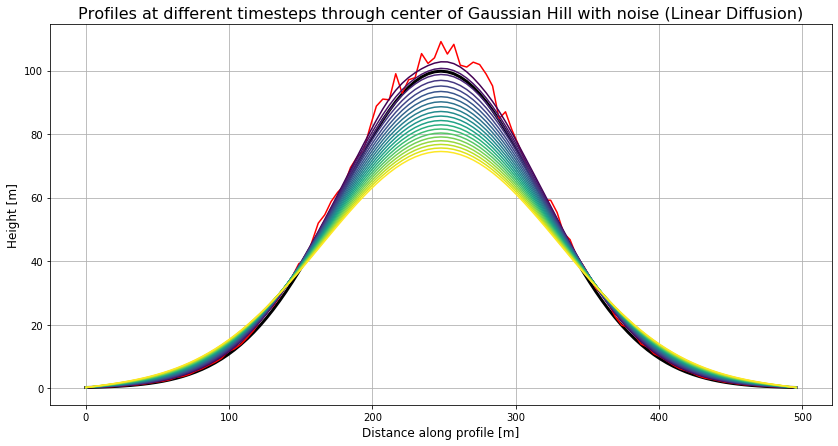

In [14]:
ghn_ld1 = mg.node_vector_to_raster(gh_noise, flip_vertically=True)

crosssection_center_noise_1 = mg.node_vector_to_raster(ghn_ld1, flip_vertically=True)[:,np.int(np.round(n/2))]
crosssection_center_ycoords_noise_1 = mg.node_vector_to_raster(mg.node_y, flip_vertically=True)[:,np.int(np.round(n/2))]

fg2, ax = pl.subplots(1, 1)
ax.plot(crosssection_center_ycoords, crosssection_center, 'k', linewidth=3, label='Org. Gaussian Hill')
ax.grid()
ax.set_xlabel('Distance along profile [m]', fontsize=12)
ax.set_ylabel('Height [m]', fontsize=12)
ax.set_title('Profiles at different timesteps through center of Gaussian Hill with noise (Linear Diffusion)', fontsize=16)
ax.plot(crosssection_center_ycoords_noise_1, crosssection_center_noise_1, 'r', label='GH w/ noise')

crosssection_center_dt = np.empty((time_steps, len(crosssection_center_d1)))
crosssection_center_ycoords_dt = np.empty((time_steps, len(crosssection_center_ycoords_d1)))
colors = pl.cm.viridis(np.linspace(0,1,time_steps))
for i in range(time_steps):
    ld.run_one_step(dt)
    gh_ld = mg.node_vector_to_raster(ghn_ld1, flip_vertically=True)
    
    crosssection_center_dt[i,:] = mg.node_vector_to_raster(gh_ld, flip_vertically=True)[:,np.int(np.round(n/2))]
    crosssection_center_ycoords_dt[i,:] = mg.node_vector_to_raster(mg.node_y, flip_vertically=True)[:,np.int(np.round(n/2))]
    ax.plot(crosssection_center_ycoords_dt[i,:], crosssection_center_dt[i,:], color=colors[i], label='dt=%d'%(dt))    
    print('%d'%(i))

Note that the noisy Gaussian Hill surface has been rapidly smoothed.

## Adding Fluvial Erosion to a Gaussian Hill through the FastScapeEroder
A description of the [FastScapeEroder](https://landlab.readthedocs.io/en/master/reference/components/stream_power.html) lists the options. Here, we setup the Gaussian Hill (without noise) and use a $K=1e-4$ and $m=0.5$ and $n=1$ for the stream-power erosion law. We perform the modeling in steps of 5000 y. A standard output of fluvial erosion modeling is the flow accumulation (drainage area) that is shown below. The output of single erosion step is shown in profile form.

<ipython-input-15-e90b87772f4b>:19: RuntimeWarning: divide by zero encountered in log10
  pl.imshow(np.log10(np.reshape(fr.node_drainage_area, (n,n))))


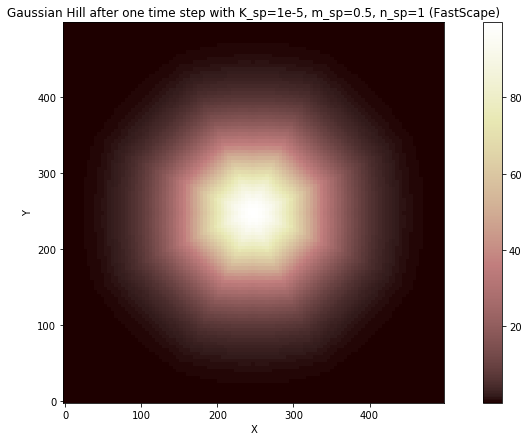

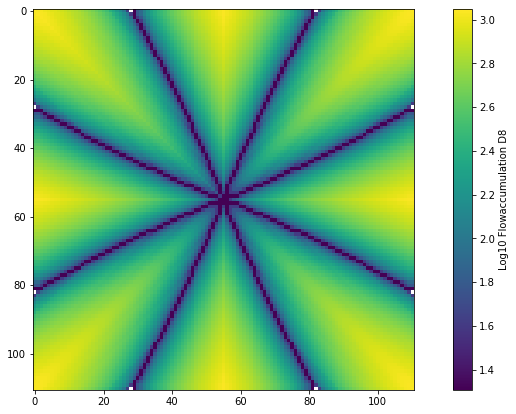

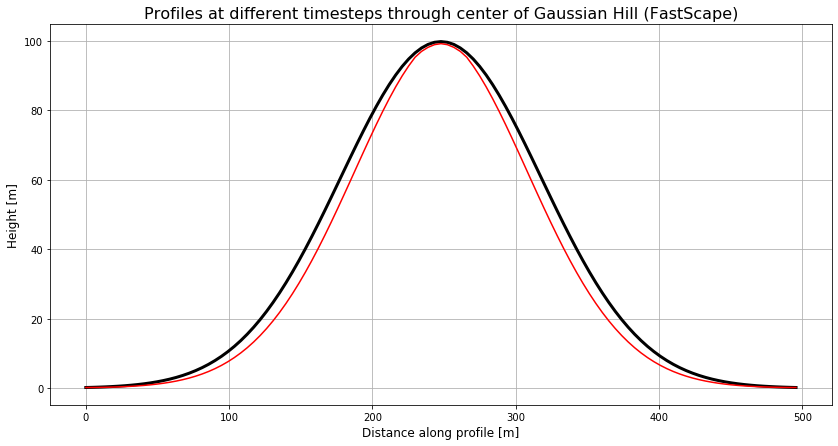

In [15]:
from landlab.components import FlowAccumulator, FastscapeEroder

x,y,z = gaussian_hill_elevation(n)
z = z*100

mg = RasterModelGrid((n, n), node_spacing)
gh_org = mg.add_field('node', 'topographic__elevation', z, units='meters', copy=True, clobber=False)

fr = FlowAccumulator(mg, flow_director='D8')
fse = FastscapeEroder(mg, K_sp = 1e-4, m_sp=0.5, n_sp=1.)
fr.run_one_step()
fse.run_one_step(dt=5000.)

fg7 = pl.figure()
imshow_grid(mg, 'topographic__elevation', plot_name='Gaussian Hill after one time step with K_sp=1e-5, m_sp=0.5, n_sp=1 (FastScape)', 
            allow_colorbar=True)

pl.figure()
pl.imshow(np.log10(np.reshape(fr.node_drainage_area, (n,n))))
cb=pl.colorbar()
cb.set_label('Log10 Flowaccumulation D8')

fg2, ax = pl.subplots(1, 1)
gh_fse = fse.grid.node_vector_to_raster(gh_org, flip_vertically=True)

crosssection_center_fse_1 = mg.node_vector_to_raster(gh_fse, flip_vertically=True)[:,np.int(np.round(n/2))]
crosssection_center_ycoords_fse_1 = mg.node_vector_to_raster(mg.node_y, flip_vertically=True)[:,np.int(np.round(n/2))]
ax.plot(crosssection_center_ycoords, crosssection_center, 'k', linewidth=3, label='Org. Gaussian Hill')
ax.grid()
ax.set_xlabel('Distance along profile [m]', fontsize=12)
ax.set_ylabel('Height [m]', fontsize=12)
ax.set_title('Profiles at different timesteps through center of Gaussian Hill (FastScape)', fontsize=16)
ax.plot(crosssection_center_ycoords_fse_1, crosssection_center_fse_1, 'r', label='noise')


Next, we perform iterative steps and plot a profile across the eroding Gaussian Hill at every step.

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


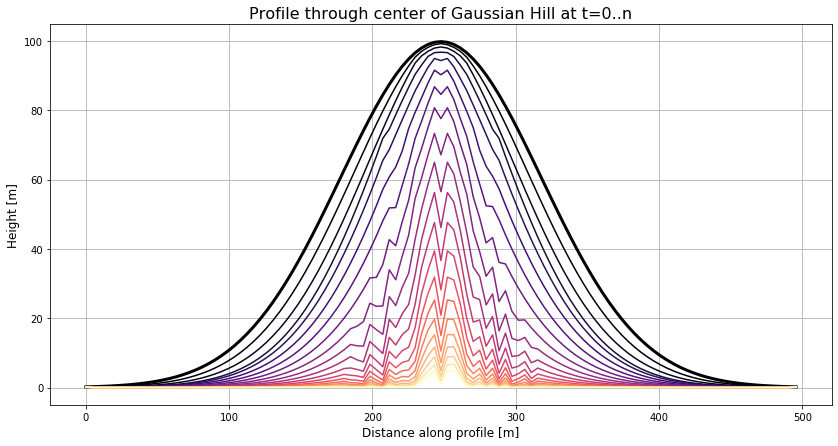

In [16]:
x,y,z = gaussian_hill_elevation(n)
z = z*100

mg = RasterModelGrid((n, n), node_spacing)
gh_org = mg.add_field('node', 'topographic__elevation', z, units='meters', copy=True, clobber=False)

fr = FlowAccumulator(mg, flow_director='D8')
fse = FastscapeEroder(mg, K_sp = 1e-4, m_sp=0.5, n_sp=1.)

fg2, ax2 = pl.subplots(1, 1)
ax2.plot(crosssection_center_ycoords, crosssection_center, 'k', linewidth=3, label='Org. Gaussian Hill')
ax2.grid()
ax2.set_xlabel('Distance along profile [m]', fontsize=12)
ax2.set_ylabel('Height [m]', fontsize=12)
ax2.set_title('Profile through center of Gaussian Hill at t=0..n', fontsize=16)

dt=5000.
time_steps = 20
crosssection_center_dt = np.empty((time_steps, len(crosssection_center_d1)))
crosssection_center_ycoords_dt = np.empty((time_steps, len(crosssection_center_ycoords_d1)))
colors = pl.cm.magma(np.linspace(0,1,time_steps))
for i in range(time_steps):
    fr.run_one_step()
    fse.run_one_step(dt)
    gh_fse = mg.node_vector_to_raster(gh_org, flip_vertically=True)
    
    crosssection_center_dt[i,:] = mg.node_vector_to_raster(gh_fse, flip_vertically=True)[:,np.int(np.round(n/2))]
    crosssection_center_ycoords_dt[i,:] = mg.node_vector_to_raster(mg.node_y, flip_vertically=True)[:,np.int(np.round(n/2))]
    ax2.plot(crosssection_center_ycoords_dt[i,:], crosssection_center_dt[i,:], color=colors[i], label='i=%d'%(i))    
    print('%d'%(i))



Note the different shape of the resulting landscape and compare it to the profile resoluts from the linear diffusion shown above. The resulting topography and drainage network is plotted below.

<ipython-input-17-7e008c14d7dc>:6: RuntimeWarning: divide by zero encountered in log10
  pl.imshow(np.log10(np.reshape(fr.node_drainage_area, (n,n))))


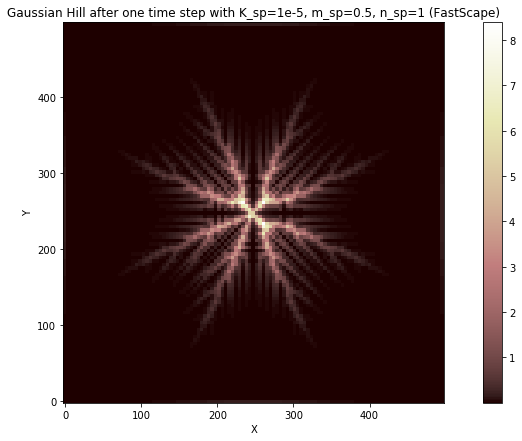

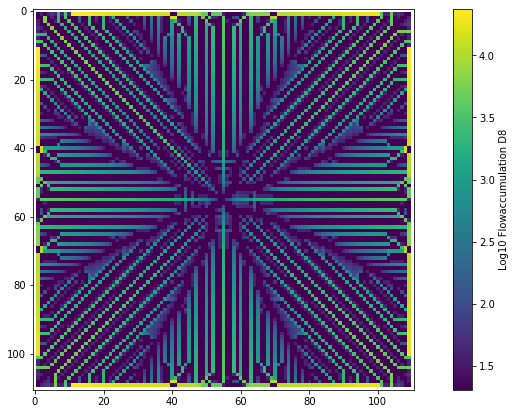

In [17]:
fg7 = pl.figure()
imshow_grid(mg, 'topographic__elevation', plot_name='Gaussian Hill after one time step with K_sp=1e-5, m_sp=0.5, n_sp=1 (FastScape)', 
            allow_colorbar=True)

pl.figure()
pl.imshow(np.log10(np.reshape(fr.node_drainage_area, (n,n))))
cb=pl.colorbar()
cb.set_label('Log10 Flowaccumulation D8')
